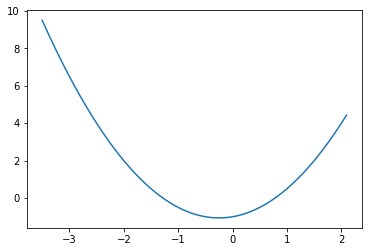

In [1]:
import numpy as np
from matplotlib import pyplot as plt

class Function1D:
    def __init__(self, factor_vector, x_min, x_max, detail=1000):
        assert len(factor_vector) > 0
        self.x = np.arange(x_min, x_max, (x_max - x_min) / detail)
        self.y = np.zeros_like(self.x)
        for i in range(detail):
            for j in range(len(factor_vector)):
                self.y[i] += factor_vector[j] * self.x[i] ** j

factors = [-1, 0.5, 1]
x_min = -3.5
x_max = 2.1
detail = 1000
f1 = Function1D(factors, x_min, x_max, detail)
plt.plot(f1.x, f1.y)

In [2]:
from scipy import optimize

x0 = 7

def function1D_continous(x):
    y = 0
    for i in range(len(factors)):
        y += factors[i] * x ** i
    return y
        
root = optimize.newton(function1D_continous, x0)

print("Root: {}".format(root))

Root: 0.7807764064044151


# Implementing Visualization

## Models

In [3]:
#not implemented

class N_To_One_DenseLayer:
    def __init__(self, weights, activation_function=None):
        self.weights = weights
        self.activation_function = activation_function
    
    def predict(input_data):
        assert len(input_data) == len(self.weights)
        for i in range(len(self.weights)):
            pass

The following code is originally from https://github.com/makeyourownneuralnetwork/makeyourownneuralnetwork/blob/master/part2_neural_network.ipynb as of 2021-05-26 and has been slightly altered to fit this project

In [4]:
import numpy
# scipy.special for the sigmoid function expit()
import scipy.special

sigmoid = lambda x: scipy.special.expit(x)
identity = lambda x: x

# neural network class definition
class NeuralNetwork:
    
    
    # initialise the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, activation_function=identity):
        # set number of nodes in each input, hidden, output layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        # link weight matrices, wih and who
        # weights inside the arrays are w_i_j, where link is from node i to node j in the next layer
        # w11 w21
        # w12 w22 etc 
        self.wih = numpy.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))
        
        self.activation_function = activation_function
        
        pass
    
    def get_params(self):
        return np.concatenate((self.wih.flatten(), self.who.flatten()))
    
    def update(self, params):
        assert params.shape == self.get_params().shape
        wih = params[:self.inodes * self.hnodes]
        who = params[self.inodes * self.hnodes:]
        self.wih = wih.reshape(self.wih.shape)
        self.who = who.reshape(self.who.shape)
        pass
    
    def predict(self, inputs_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs

In [5]:
# number of input, hidden and output nodes
input_nodes = 1
hidden_nodes = 1
output_nodes = 1

# create instance of neural network
model = NeuralNetwork(input_nodes, hidden_nodes, output_nodes)
#print(model.predict([1.0, 0.5, -1.5]))

print('old wih \n', model.wih)
print('old who \n', model.who)
update_params = model.get_params()
update_params += np.full(shape=update_params.shape, fill_value=1)
print(model.get_params())
print(update_params)
model.update(update_params)
print('new wih \n', model.wih)
print('new who \n', model.who)
print(model.get_params())

old wih 
 [[0.67165296]]
old who 
 [[0.72879444]]
[0.67165296 0.72879444]
[1.67165296 1.72879444]
new wih 
 [[1.67165296]]
new who 
 [[1.72879444]]
[1.67165296 1.72879444]


Code from https://github.com/makeyourownneuralnetwork/makeyourownneuralnetwork/blob/master/part2_neural_network.ipynb ends here.

## Loss Functions

In [6]:
def mse(model, input_data, output_objective):
    error = (model.predict(input_data) - output_objective) ** 2
    return np.linalg.norm(error)

## Decent

In [7]:
#tested
#ensures: reset

def get_gradient(model, f, input_data, output_objective, delta_on_params=10**(-15)):
    params = model.get_params()
    gradient = np.zeros_like(params)
    for i in range(len(gradient)):
        alt_params = np.copy(params)
        alt_params[i] += delta_on_params
        f_normal = f(model, input_data, output_objective)
        model.update(alt_params)
        f_alt = f(model, input_data, output_objective)
        gradient[i] = (f_alt - f_normal) / delta_on_params
        model.update(params)
    return gradient

In [8]:
#updates the model: because I refuse to write clean code :D

def evaluate_model(model, f, input_data, output_objective, params_old, params_new):
    model.update(params_old)
    f_old = f(model, input_data, output_objective)
    model.update(params_new)
    f_new = f(model, input_data, output_objective)
    return f_new - f_old

In [9]:
def adam(model, f, input_data, output_objective,
         alpha=0.001, beta1=0.9, beta2=0.999, epsilon=10**(-8), convergence_epsilon=10**(-8), t_max=100000):
    params = model.get_params()
    params_old = np.full(shape=params.shape, fill_value=float('inf')) #first iteration always results in training
    m = np.zeros_like(params)
    v = np.zeros_like(params)
    t = 0
    
    #additional stuff for animation
    params_history = np.zeros(shape=(t_max, params.shape[0]))
    f_history = np.zeros(shape=t_max)
    params_history[t] = params
    f_history[t] = f(model, input_data, output_objective)
    #additional stuff ends here
    
    while abs(evaluate_model(model, f, input_data, output_objective, params_old, params)) > convergence_epsilon:
        params_old = np.copy(params)
        if t > t_max:
            raise RuntimeError(f"No convergence after {t - 1} iterations")
        t += 1
        gradient = get_gradient(model, f, input_data, output_objective)
        m = beta1 * m + (1 - beta1) * gradient
        v = beta2 * v + (1 - beta2) * np.square(gradient)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        params -= alpha * m_hat / (np.sqrt(v_hat) + epsilon)
        
        #additional stuff for animation
        params_history[t] = params
        f_history[t] = f(model, input_data, output_objective)
        #additional stuff ends here
        
    return params, t, params_history, f_history


inputs = [0.7]
outputs = [-1.0]
function_used = mse
#model.update(np.array([1.0, 1.0, 1.0]))
print('initial prediction:', model.predict(inputs))
params, t_end, params_history, f_history = adam(model, function_used, inputs, outputs)
model.update(params)
print('optimized prediction:', model.predict(inputs))
optimized_params = params
print('optimized params:', optimized_params)
print(f'after {t_end} iterations')

initial prediction: [[2.02296104]]
optimized prediction: [[-0.9992089]]
optimized params: [-1.13794263  1.25440532]
after 6257 iterations


In [10]:
def actual_loss_function_2D(teta0, teta1, model, f, input_data, output_objective):
    assert model.get_params().shape == (2,)
    params = np.array([teta0, teta1])
    model.update(params)
    return f(model, input_data, output_objective)

print(model.get_params().shape)
teta0_star = optimized_params[0]
teta1_star = optimized_params[1]
print(actual_loss_function_2D(teta0_star, teta1_star, model, function_used, inputs, outputs))

(2,)
6.258327955143543e-07


In [11]:
def get_decent_line(params_history, f_history, t_end):
    decent_line = np.empty((t_end + 1, 3))
    decent_line[:, 0] = params_history[:t_end + 1, 0]
    decent_line[:, 1] = params_history[:t_end + 1, 1]
    decent_line[:, 2] = f_history[:t_end + 1]
    return decent_line

decent_lines = [get_decent_line(params_history, f_history, t_end)]

<IPython.core.display.Javascript object>


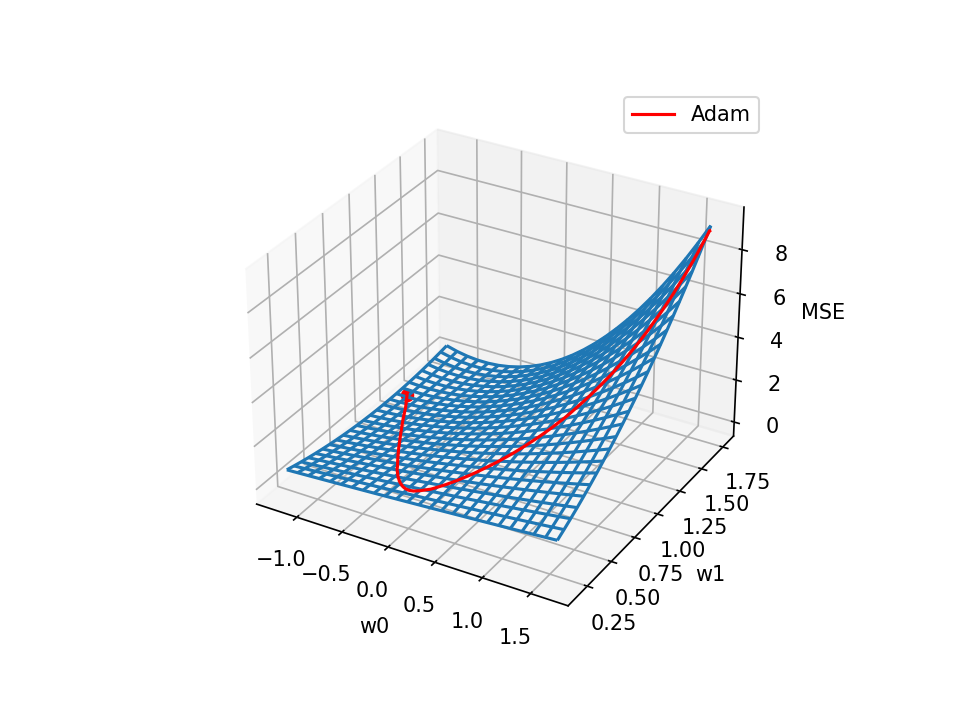

In [12]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy
#import ipywidgets as widgets

def loss_2D(model, f, input_data, output_objective, detail=50, teta0_min=0, teta0_max=1, teta1_min=0, teta1_max=1):
    results = np.zeros(shape=(detail, detail))
    X = np.zeros(shape=detail)
    Y = np.zeros(shape=detail)
    for i in range(detail):
        teta0 = teta0_min + i * (teta0_max - teta0_min) / detail
        X[i] = teta0
        for j in range(detail):
            teta1 = teta1_min + j * (teta1_max - teta1_min) / detail
            params = np.array([teta0, teta1])
            model.update(params)
            results[j, i] = f(model, input_data, output_objective) #this is switched but fixed the bug @ToDo: investigate!
    for j in range(detail):
        teta1 = teta1_min + j * (teta1_max - teta1_min) / detail
        Y[j] = teta1
    return X, Y, results

def plot_loss_2D(decent_lines, model, f, input_data, output_objective, params_history, t_end, detail=25, margin=0.1):
    
    teta0_max = -float('inf')
    teta0_min = float('inf')
    teta1_max = -float('inf')
    teta1_min = float('inf')
    for decent_line in decent_lines:
        teta0_max = max(np.amax(decent_line[:, 0]) + margin, teta0_max)
        teta0_min = min(np.amin(decent_line[:, 0]) - margin, teta0_min)
        teta1_max = max(np.amax(decent_line[:, 1]) + margin, teta1_max)
        teta1_min = min(np.amin(decent_line[:, 1]) - margin, teta1_min)
        model.update(optimized_params)
        f_star = f(model, input_data, output_objective)
        X, Y, results = loss_2D(model, f, input_data, output_objective, detail, teta0_min, teta0_max, teta1_min, teta1_max)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(X, Y)
    Z = results
    ax.plot_wireframe(X, Y, Z, zorder=-10)
    colors = ['r', 'g', 'y', 'c', 'm', 'k']
    decent_methods = ['Adam', 'SGD'] #change labels here, be careful with the order
    for i, decent_line in enumerate(decent_lines):
        ax.plot(decent_line[:, 0], decent_line[:, 1], decent_line[:, 2], c=colors[i % len(colors)],
                zorder=10, label=decent_methods[i])
        teta0_star = decent_line[-1, 0]
        teta1_star = decent_line[-1, 1]
        ax.scatter(teta0_star, teta1_star, f_star, c=colors[i % len(colors)], s=30, zorder=100)
    ax.legend()
    ax.set_xlabel('w0')
    ax.set_ylabel('w1')
    ax.set_zlabel('MSE') #change to function used

plot_model = deepcopy(model)
plot_loss_2D(decent_lines, plot_model, function_used, inputs, outputs, params_history, t_end)

In [13]:
model.update(params_history[0]) #start with the same initialization as Adam

def sgd(model, f, input_data, output_objective, lr=0.01, convergence_epsilon=10**(-8), t_max=100000):
    params = model.get_params()
    params_old = np.full(shape=params.shape, fill_value=float('inf')) #first iteration always results in training
    t = 0
    
    #additional stuff for animation
    params_history = np.zeros(shape=(t_max, params.shape[0]))
    f_history = np.zeros(shape=t_max)
    params_history[t] = params
    f_history[t] = f(model, input_data, output_objective)
    #additional stuff ends here
    
    while abs(evaluate_model(model, f, input_data, output_objective, params_old, params)) > convergence_epsilon:
        params_old = np.copy(params)
        if t > t_max:
            raise RuntimeError(f"No convergence after {t - 1} iterations")
        t += 1
        
        gradient = get_gradient(model, f, input_data, output_objective)
        params -= lr * gradient
        
        #additional stuff for animation
        params_history[t] = params
        f_history[t] = f(model, input_data, output_objective)
        #additional stuff ends here
        
    return params, t, params_history, f_history

inputs = [0.7]
outputs = [-1.0]
function_used = mse
#model.update(np.array([1.0, 1.0, 1.0]))
print('initial prediction:', model.predict(inputs))
params, t_end, params_history, f_history = sgd(model, function_used, inputs, outputs)
model.update(params)
print('optimized prediction:', model.predict(inputs))
optimized_params = params
print('optimized params:', optimized_params)
print(f'after {t_end} iterations')
decent_lines.append(get_decent_line(params_history, f_history, t_end))

initial prediction: [[2.02296104]]
optimized prediction: [[-0.99962263]]
optimized params: [-1.12807378  1.2659033 ]
after 443 iterations


<IPython.core.display.Javascript object>


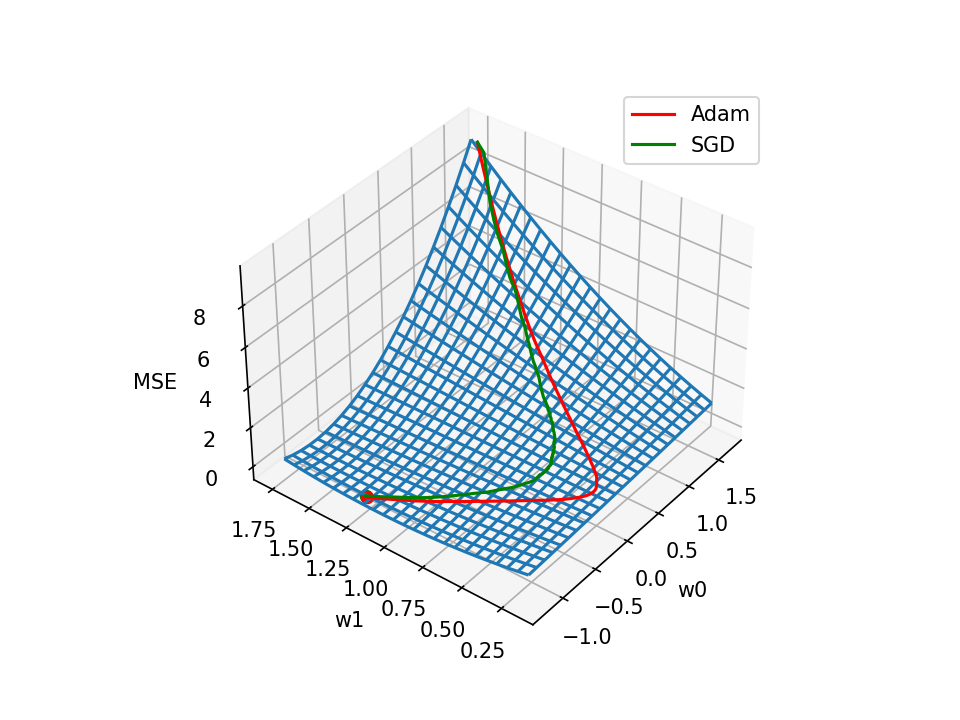

In [14]:
plot_model = deepcopy(model)
plot_loss_2D(decent_lines, plot_model, function_used, inputs, outputs, params_history, t_end)